Basé sur l'article "[The KL-UCB algortihm for bounded stochastic bandits and beyond](https://arxiv.org/abs/1102.2490)" de **Aurélien Garivier** et **Olivier Cappé**.

In [41]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.stats import truncexpon
import time

%matplotlib inline

In [42]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Scénario 3
2 Bras suivant une récompense exponentielle tronquée

### Paramètres du scénario

In [43]:
#Params du scenario 2
p = np.array([1/5, 1/4, 1/3, 1/2, 1]) #Paramètres des lois exponentielles
K = p.shape[0] #Nombre de bras
delta = ( np.ones(K)*np.max(p) ) - p
T= 5000 #Nombre de périodes
runs = 100 #Nombre d'itérations

print("p:", p)
print("Delta:", delta)

p: [ 0.2         0.25        0.33333333  0.5         1.        ]
Delta: [ 0.8         0.75        0.66666667  0.5         0.        ]


## UCB ($\alpha=3$)

In [44]:
alpha = 3
actions_list_ucb3 = []
total_rewards_list_ucb3 = np.zeros((runs,T))
start_time = time.time()

for run in range(runs):    
    #ucb Params Iinitialization
    N = np.zeros(K) #Nb de fois ou le bras 1 ou 2 a été tiré
    rewards = np.zeros((K, T), dtype=np.int) #Recompense avec chaque bras
    actions = np.zeros((K, T), dtype=np.int) #Bras choisi à chaque étape
    ucb = np.zeros(K) #ucb pour chaque bras

    #On commence en explorant les 2 bras au moins une fois
    # 0 < t < K 
    for t in range(K):
        N[t]=1
        rewards[t,t]= truncexpon.rvs(10, scale = p[t])
        actions[t,t]=1

    #t >= K
    for t in range(K, T):
        for k in range(K):
            ucb[k] = np.sum(rewards[k,:t])/N[k]+np.sqrt((alpha*math.log(t))/(2*N[k]))

        select = np.argmax(ucb)
        N[select] += 1
        actions[select,t] = 1
        rewards[select,t] = truncexpon.rvs(10, scale = p[select])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_ucb3[run,:] = np.copy(total_rewards)
    actions_list_ucb3.append(np.copy(actions))

time_spent_ucb3 = time.time() - start_time
print("Time for UCB, with alpha = 3 and T =", T, ", runs =", runs, ":", time_spent_ucb3, "seconds")

Time for UCB, with alpha = 3 and T = 5000 , runs = 100 : 196.11449694633484 seconds


## KL-UCB : Bernoulli

In [45]:
%%capture
klucb_bernoulli = kl_ucb_policy.KLUCBPolicy(K, kl_ucb_policy.klucb_upper_bisection)

total_rewards_list_klucb_bernoulli = np.zeros((runs,T))
actions_list_klucb_bernoulli = []
start_time = time.time()

for run in range(runs):
    klucb_bernoulli.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm = klucb_bernoulli.select_next_arm()
        actions[arm, t] = 1
        rewards[arm, t] = truncexpon.rvs(10, scale = p[arm])
        klucb_bernoulli.update_state(arm, rewards[arm, t])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_klucb_bernoulli[run,:] = np.copy(total_rewards)
    actions_list_klucb_bernoulli.append(np.copy(actions))

time_spent_klucb_bernoulli = time.time() - start_time

In [46]:
print("Time for KL-UCB (Bernoulli), with T =", T, ", runs =", runs, ":", (time_spent_klucb_bernoulli), "seconds")

Time for KL-UCB (Bernoulli), with T = 5000 , runs = 100 : 1016.5888690948486 seconds


## KL-UCB : Exponentiel

In [47]:
%%capture
klucb_exponential = kl_ucb_policy.KLUCBPolicy(K, kl_ucb_policy.klucb_upper_bisection, kl_ucb_policy.kl_exponential)

total_rewards_list_klucb_exponential = np.zeros((runs,T))
actions_list_klucb_exponential = []
start_time = time.time()

for run in range(runs):
    klucb_exponential.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.int)

    for t in range(T):
        arm = klucb_exponential.select_next_arm()
        actions[arm, t] = 1
        rewards[arm, t] = truncexpon.rvs(10, scale = p[arm])
        klucb_exponential.update_state(arm, rewards[arm, t])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Reward accumulé pour chaque bras en fonction du temps
    total_rewards = np.sum(cumulative_rewards, axis=0) #Reward sur tout les bras accumulé en fonction du temps
    total_rewards_list_klucb_exponential[run,:] = np.copy(total_rewards)
    actions_list_klucb_exponential.append(np.copy(actions))

time_spent_klucb_exponential = time.time() - start_time

In [48]:
print("Time for KL-UCB (Exponentiel), with T =", T, ", runs =", runs, ":", (time_spent_klucb_exponential), "seconds")

Time for KL-UCB (Exponentiel), with T = 5000 , runs = 100 : 949.8942663669586 seconds


## Gain moyen total obtenu avec UCB et KL-UCB

In [49]:
mean_total_rewards_list_ucb3 = np.mean(total_rewards_list_ucb3, axis=0)
print("t & Reward (total) UCB :",t, mean_total_rewards_list_ucb3[t] )
mean_total_rewards_list_klucb_bernoulli = np.mean(total_rewards_list_klucb_bernoulli, axis=0)
print("t & Reward (total) KL-UCB (Bernoulli) :",t, mean_total_rewards_list_klucb_bernoulli[t] )
mean_total_rewards_list_klucb_exponential = np.mean(total_rewards_list_klucb_exponential, axis=0)
print("t & Reward (total) KL-UCB (Exponentiel) :",t, mean_total_rewards_list_klucb_exponential[t] )

t & Reward (total) UCB : 4999 2836.98
t & Reward (total) KL-UCB (Bernoulli) : 4999 2849.31
t & Reward (total) KL-UCB (Exponentiel) : 4999 1728.06


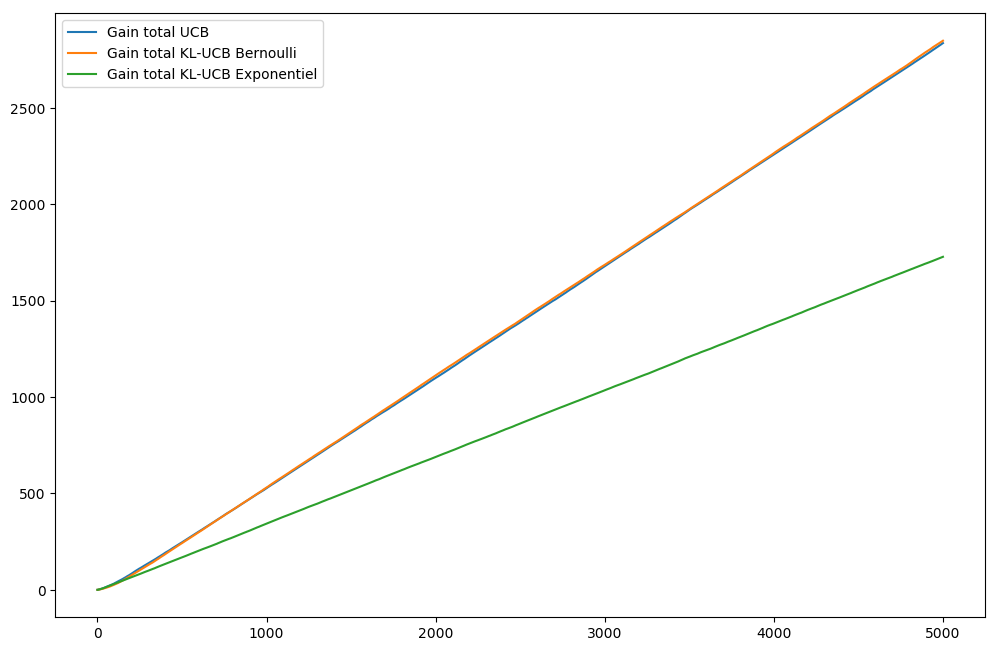

In [50]:
#Plot
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(mean_total_rewards_list_ucb3[:], linestyle='-', label='Gain total UCB')
ax1.plot(mean_total_rewards_list_klucb_bernoulli[:], linestyle='-', label='Gain total KL-UCB Bernoulli')
ax1.plot(mean_total_rewards_list_klucb_exponential[:], linestyle='-', label='Gain total KL-UCB Exponentiel')

ax1.legend(loc='best')
plt.show()

## Evolution moyenne du regret en fonction de t

In [51]:
#UCB
total_action_ucb = np.zeros((K,T))
for actions_ucb3 in actions_list_ucb3:
    total_action_ucb += np.cumsum(actions_ucb3, axis=1) #Nb d'actions accumulé sur chaque bras
total_action_ucb = total_action_ucb / runs
regret_cumule_ucb = np.dot(delta, total_action_ucb[:,:]) #Regret accumulé

#KL-UCB Bernoulli
total_action_klucb_bernoulli = np.zeros((K,T))
for actions_klucb_bernoulli in actions_list_klucb_bernoulli:
    total_action_klucb_bernoulli += np.cumsum(actions_klucb_bernoulli, axis=1) #Nb d'actions accumulé sur chaque bras
total_action_klucb_bernoulli = total_action_klucb_bernoulli / runs
regret_cumule_klucb_bernoulli = np.dot(delta, total_action_klucb_bernoulli[:,:]) #Regret accumulé

#KL-UCB Exponentiel
total_action_klucb_exponential = np.zeros((K,T))
for actions_klucb_exponential in actions_list_klucb_exponential:
    total_action_klucb_exponential += np.cumsum(actions_klucb_exponential, axis=1) #Nb d'actions accumulé sur chaque bras
total_action_klucb_exponential = total_action_klucb_exponential / runs
regret_cumule_klucb_exponential = np.dot(delta, total_action_klucb_exponential[:,:]) #Regret accumulé

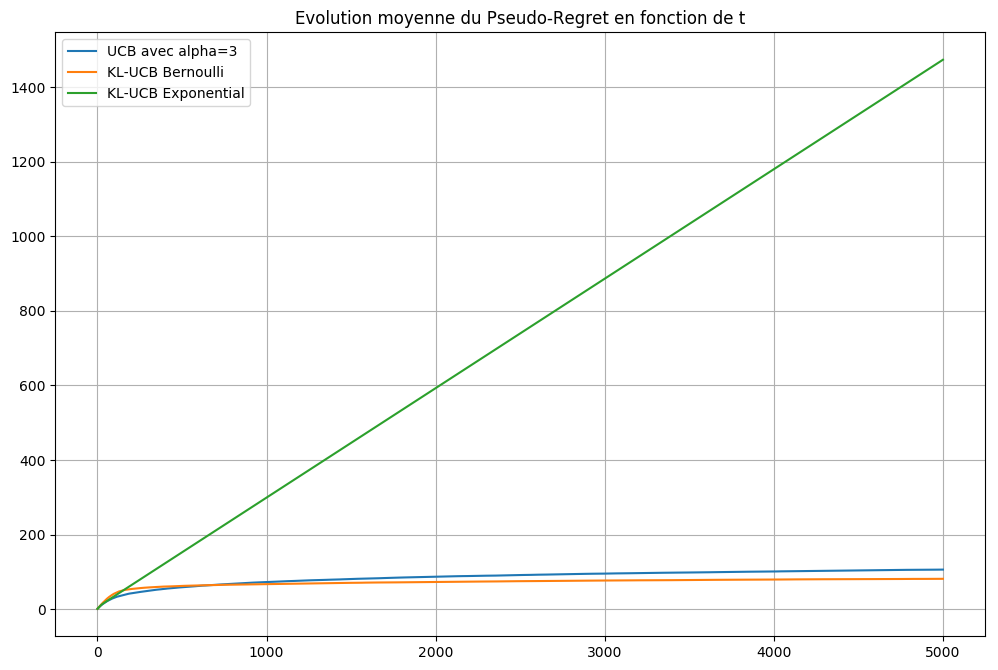

In [86]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_ucb[:], linestyle='-', label='UCB avec alpha=3')
ax1.plot(regret_cumule_klucb_bernoulli[:], linestyle='-', label='KL-UCB Bernoulli')
ax1.plot(regret_cumule_klucb_exponential[:], linestyle='-', label='KL-UCB Exponential')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution moyenne du Pseudo-Regret en fonction de t')
#ax1.xscale('log')
plt.show()

## Evolution médiane du regret en fonction de t

In [90]:
#UCB
L = len(actions_list_ucb3)
liste_actions_ucb = np.zeros((K, T, L))
for l in range(L):
    liste_actions_ucb[:,:,l] = np.cumsum(actions_ucb3, axis=1) #Nb d'actions accumulé sur chaque bras
mediane_regret_ucb = np.median(liste_actions_ucb, axis = 2)
regret_median_cumule_ucb = np.dot(delta, mediane_regret_ucb[:,:]) #Regret accumulé

#KL-UCB Bernoulli
L = len(actions_list_klucb_bernoulli)
liste_actions_klucb_bernoulli = np.zeros((K, T, L))
for l in range(L):
    liste_actions_klucb_bernoulli[:,:,l] = np.cumsum(actions_klucb_bernoulli, axis=1) #Nb d'actions accumulé sur chaque bras
mediane_regret_klucb_bernoulli = np.median(liste_actions_klucb_bernoulli, axis = 2)
regret_median_cumule_klucb_bernoulli = np.dot(delta, mediane_regret_klucb_bernoulli[:,:]) #Regret accumulé

#KL-UCB Exponentiel
L = len(actions_list_klucb_exponential)
liste_actions_klucb_exponential = np.zeros((K, T, L))
for l in range(L):
    liste_actions_klucb_exponential[:,:,l] = np.cumsum(actions_klucb_exponential, axis=1) #Nb d'actions accumulé sur chaque bras
mediane_regret_klucb_exponential = np.median(liste_actions_klucb_exponential, axis = 2)
regret_median_cumule_klucb_exponential = np.dot(delta, mediane_regret_klucb_exponential[:,:]) #Regret accumulé

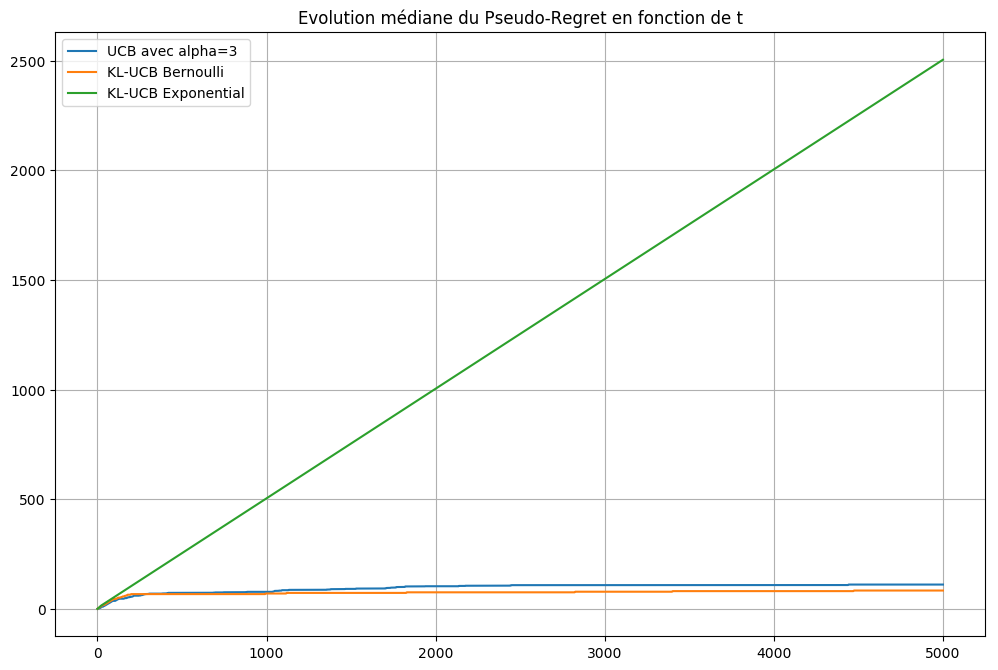

In [91]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_median_cumule_ucb[:], linestyle='-', label='UCB avec alpha=3')
ax1.plot(regret_median_cumule_klucb_bernoulli[:], linestyle='-', label='KL-UCB Bernoulli')
ax1.plot(regret_median_cumule_klucb_exponential[:], linestyle='-', label='KL-UCB Exponential')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution médiane du Pseudo-Regret en fonction de t')
#ax1.xscale('log')
plt.show()

## Distribution du regret

In [65]:
TO = 4999

#UCB
distribution_regret_ucb = []
for actions_ucb in actions_list_ucb3:
    distribution_regret_ucb.append(np.dot(delta, np.sum(actions_ucb[:,:T0], axis=1)))

#KL-UCB Bernoulli
distribution_regret_klucb_bernoulli = []
for actions_klucb in actions_list_klucb_bernoulli:
    distribution_regret_klucb_bernoulli.append(np.dot(delta, np.sum(actions_klucb[:,:T0], axis=1)))

#KL-UCB Exponentiel
distribution_regret_klucb_exponential = []
for actions_klucb in actions_list_klucb_exponential:
    distribution_regret_klucb_exponential.append(np.dot(delta, np.sum(actions_klucb[:,:T0], axis=1)))

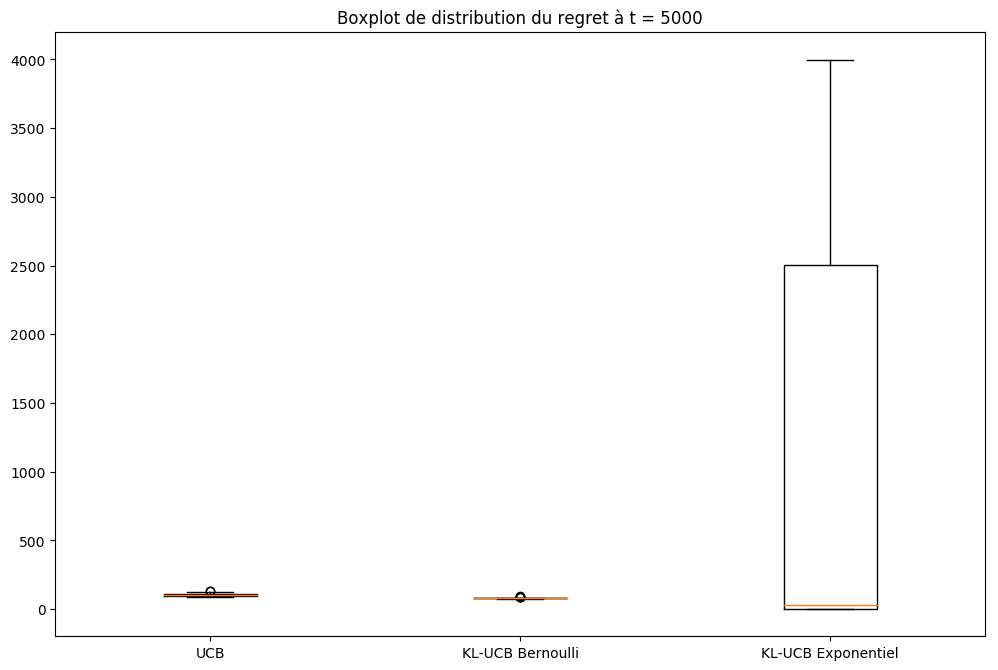

In [75]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_ucb, 
        distribution_regret_klucb_bernoulli,
        distribution_regret_klucb_exponential
    ])
ax.set_xticklabels([
        'UCB', 
        'KL-UCB Bernoulli', 
        'KL-UCB Exponentiel'
    ])

ax.set_title('Boxplot de distribution du regret à t = 5000')
plt.show()

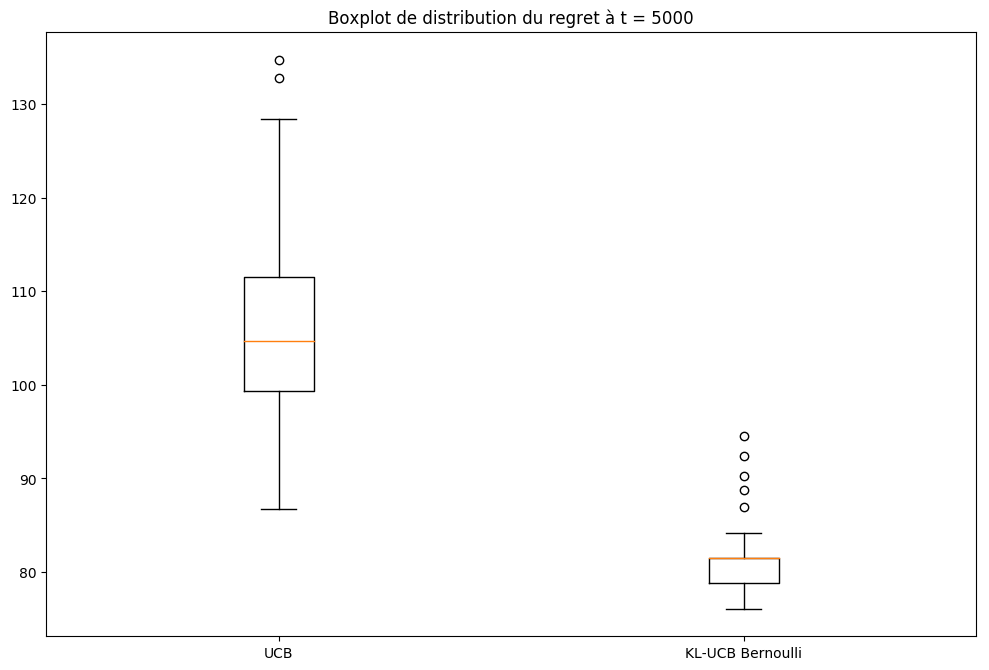

In [76]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_ucb, 
        distribution_regret_klucb_bernoulli
    ])
ax.set_xticklabels([
        'UCB', 
        'KL-UCB Bernoulli'
    ])

ax.set_title('Boxplot de distribution du regret à t = 5000')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'ylim'

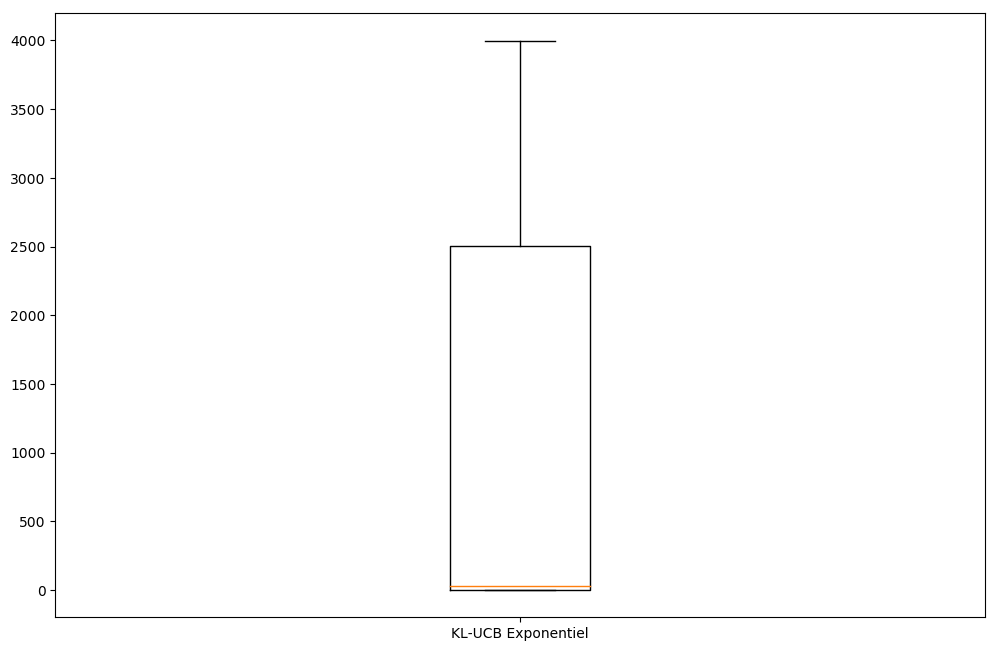

In [94]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_klucb_exponential
    ])
ax.set_xticklabels([
        'KL-UCB Exponentiel'
    ])
ax.set_title('Boxplot de distribution du regret à t = 5000')
plt.show()